In [11]:
# devtools::load_all('.')

In [5]:
library(tidyverse)
library(data.table)
library(magrittr)
library(harmony)
# library(singlecellmethods)

# kmeans

In [4]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
library(mvtnorm)
library(tidyverse)

In [4]:
# Rcpp::sourceCpp('src/kmeans.cpp')

In [5]:
# ## colums are observations
# soft_kmeans <- function(X, k, max_iter=20, sigma=0.1) {
#     message('WARNING: soft_kmeans fxn uses cosine distance only')
#     Z <- cosine_normalize_cpp(X, 2)
#     Y <- stats::kmeans(t(Z), centers = k, iter.max = 25, nstart = 10)$centers %>% t() ## D x K
#     res <- soft_kmeans_cpp(Y, Z, max_iter, sigma)
#     return(res)
# }

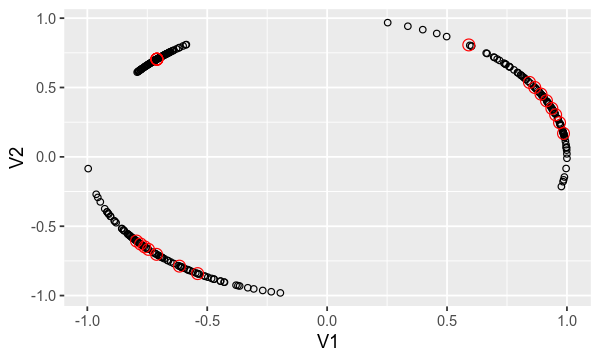

In [5]:
fig.size(3, 5)
X <- rbind(
    rmvnorm(100, mean = c(1, .5), sigma = diag(.1, 2)),
    rmvnorm(100, mean = c(-1, -1), sigma = diag(.1, 2)),
    rmvnorm(100, mean = c(-1, 1), sigma = diag(.01, 2))
) %>% 
    cosine_normalize_cpp(1) %>% 
    t()

res <- soft_kmeans(X, 21)
data.table(t(X)) %>% 
    ggplot(aes(V1, V2)) + geom_point(shape = 21) + 
    geom_point(data = data.table(t(res$Y)), color = 'red', shape = 21, size = 3)

In [10]:
devtools::install_github('immunogenomics/singlecellmethods')


✔  checking for file ‘/tmp/Rtmp8KiS4B/remotes4d752bc0a3f7/immunogenomics-singlecellmethods-ba00160/DESCRIPTION’
─  preparing ‘singlecellmethods’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  excluding invalid files
   Subdirectory 'R' contains invalid file names:
     ‘Untitled.ipynb’
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘singlecellmethods_0.1.0.tar.gz’
   


# weighted soft kmeans

In [92]:
## Test: weighted vs unweighted

In [4]:
sourceCpp('src/temp.cpp')

In [5]:
soft_kmeans <- function(X, k, w, sigma=0.1, iter.max=25, nstart=10, tol=1e-3) {
    message('WARNING: soft_kmeans fxn uses cosine distance only')
    Z <- singlecellmethods:::cosine_normalize_cpp(X, 2)
    seeds <- sample(1e6, nstart)
    if (!missing(w)) {
        score_curr <- Inf
        for (iter in seq_len(nstart)) {
            set.seed(seeds[iter])
            mediods <- sample(ncol(Z), k, prob = w)
            res_new <- soft_kmeans_weighted_cpp(Z[, mediods], Z, w, iter.max, sigma, tol)
            score_new <- tail(res_new$scores, 1)
            if (score_new < score_curr) {
                res <- res_new
                score_curr <- score_new
            }
        }
    } else {
        Y <- stats::kmeans(t(Z), k, iter.max, nstart)$centers %>% t() ## D x K
        res <- soft_kmeans_cpp(Y, Z, iter.max, sigma)        
    }
    return(res)
}



In [8]:
data(cell_lines)

table(cell_lines$meta_data$cell_type)

idx <- c(
    which(cell_lines$meta_data$cell_type == 'jurkat') %>% sample(100),
    which(cell_lines$meta_data$cell_type == 't293') %>% sample(100)
)
y <- cell_lines$meta_data$cell_type[idx]
X <- t(cell_lines$scaled_pcs[idx, 1:10])


jurkat   t293 
  1266   1104 

## Test 1: accuracy

In [9]:
sourceCpp('src/temp.cpp')

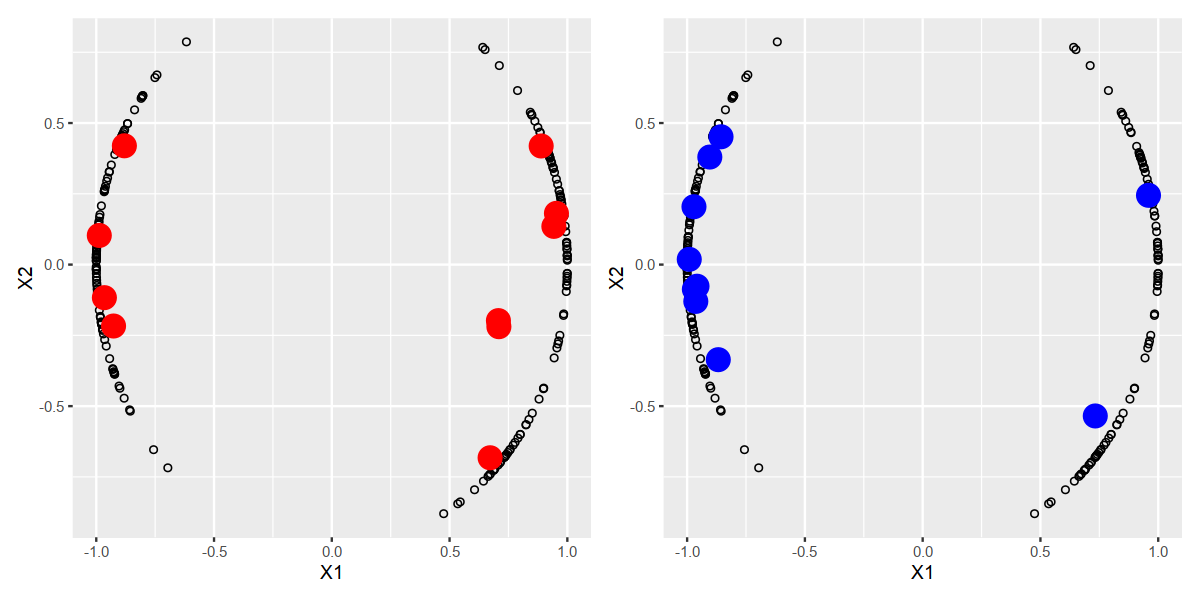

In [10]:
library(patchwork)
k <- 10
# y <- factor(y)
# weights <- as.numeric((1/prop.table(table(y)))[y])/nlevels(y)
weights <- rep(c(1, 10), c(100, 100)) %>% prop.table()
set.seed(4)
mediods <- sample(ncol(X), k)
# mediods <- c(1, 2)
# mediods
# resw <- soft_kmeans_weighted_cpp(X[, mediods], X, weights, 30, .1, 1e-4)
resw <- soft_kmeans(X, k, weights)
# resw <- soft_kmeans_weighted_cpp(X[, c(1), drop = FALSE], X, weights, 30, .1, 1e-4)
res <- singlecellmethods:::soft_kmeans(X, k, sigma = .1, max_iter = 30)

fig.size(5, 10)
# res$Y
plt <- t(X)[, 1:2] %>% 
    singlecellmethods:::cosine_normalize_cpp(1) %>%  
    data.frame() %>% 
    ggplot(aes(X1, X2)) + 
        geom_point(shape = 21) + 
        NULL
plt + 
    geom_point(size = 6, data = data.frame(t(res$Y[1:2, ])), color = 'red') +
plt +
    geom_point(size = 6, data = data.frame(t(resw$Y[1:2, ])), color = 'blue') +
NULL


In [11]:
library(singlecellmethods)
Z <- singlecellmethods:::cosine_normalize_cpp(X, 1)
dist_mat <- 2 * (1 - crossprod(res$Y, Z))
dist_mat_w <- 2 * (1 - crossprod(resw$Y, Z))
soft_kmeans_score_cpp(res$R, weights, dist_mat, .1)
# soft_kmeans_score_cpp(res$R, rep(1/200, 200), dist_mat, .1)
soft_kmeans_score_cpp(resw$R, weights, dist_mat_w, .1)


Attaching package: ‘singlecellmethods’


The following objects are masked _by_ ‘.GlobalEnv’:

    normalizeData, soft_kmeans


The following object is masked from ‘package:base’:

    rowMeans




[1] 1.721948

[1] 1.668858

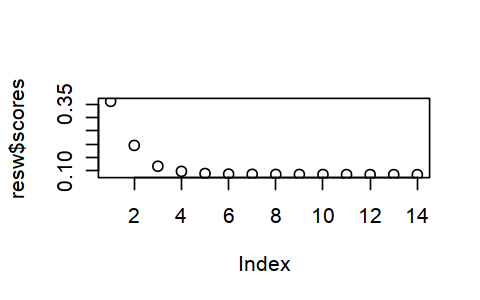

In [12]:
fig.size(2.5, 4)
plot(resw$scores)

In [13]:
# diff(resw$scores) / head(resw$scores, -1)

## Test 2: speed

In [14]:
sourceCpp('src/temp.cpp')

In [20]:
data(cell_lines)

# idx <- c(
#     which(cell_lines$meta_data$cell_type == 'jurkat') %>% sample(100),
#     which(cell_lines$meta_data$cell_type == 't293') %>% sample(100)
# )
# idx <- 1:nrow(cell_lines$meta_data)
y <- cell_lines$meta_data$cell_type
X <- t(cell_lines$scaled_pcs)

dim(X)
X <- list(c(X, X, X, X, X, X, X, X, X, X, X)) %>% purrr::reduce(rbind) %>% matrix(nrow = 20)
dim(X)
X <- X[, 1:1e4]

[1]   20 2370

[1]    20 26070

In [21]:
k <- 100

In [22]:
system.time({
    flexclust::cclust(t(X), k, method='hardcl', weights=weights)
})
    

   user  system elapsed 
 55.118   0.022  55.535 

In [23]:
system.time({
    resw <- soft_kmeans(X, k, rep(1, ncol(X)), nstart = 10, iter.max = 20)
})

   user  system elapsed 
 72.694 179.851  11.035 

In [24]:
system.time({
# profvis({
    resw <- stats::kmeans(t(X), k, nstart = 10, iter.max = 20)#soft_kmeans(X, k, rep(1, ncol(X)), nstart = 1)
})

   user  system elapsed 
  0.853   0.000   0.854 

In [26]:
# stats::kmeans

## Test 3: part of package

In [82]:
devtools::load_all('/data/srlab/ik936/harmony')

Loading harmony



In [54]:
data(cell_lines)
y <- cell_lines$meta_data$dataset
y <- factor(y)
weights <- as.numeric((1/prop.table(table(y)))[y])/nlevels(y)


In [83]:
weights <- rep(1, nrow(cell_lines$meta_data))
harmonyObj <- HarmonyMatrix(
    cell_lines$scaled_pcs,
    cell_lines$meta_data,
    c('dataset'),
    weights = weights, 
    use_weights_init = TRUE, 
    do_pca = FALSE,
    return_object = TRUE
)


Harmony 1/10

Harmony converged after 1 iterations



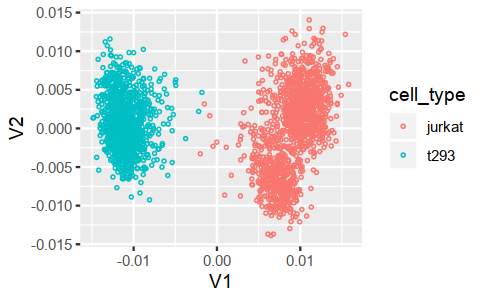

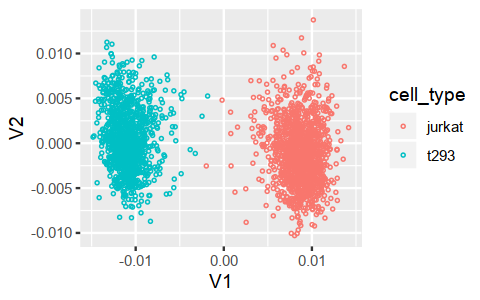

In [93]:
harmonyObj$Z_orig[1:2, ] %>% 
    t() %>% data.table() %>% 
    cbind(cell_lines$meta_data) %>% 
    ggplot(aes(V1, V2, color = cell_type)) + 
        geom_point(shape = 21, size = .5) + 
        NULL

harmonyObj$Z_corr[1:2, ] %>% 
    t() %>% data.table() %>% 
    cbind(cell_lines$meta_data) %>% 
    ggplot(aes(V1, V2, color = cell_type)) + 
        geom_point(shape = 21, size = .5) + 
        NULL


In [74]:
weights <- rep(1, ncol(X))
resw <- soft_kmeans_weighted_cpp(X[, c(1, 5, 10, 332, 281, 382)], X, weights, 20, .1, 1e-4)


# VST variable selection

In [31]:
library(Seurat)
library(tidyverse)
library(SeuratData)
library(patchwork)
data(pbmc3k)

## Seurat vst

In [2]:
pbmc3k <- NormalizeData(pbmc3k)

In [3]:
pbmc3k <- FindVariableFeatures(pbmc3k, selection.method = "vst", nfeatures = 2000)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results



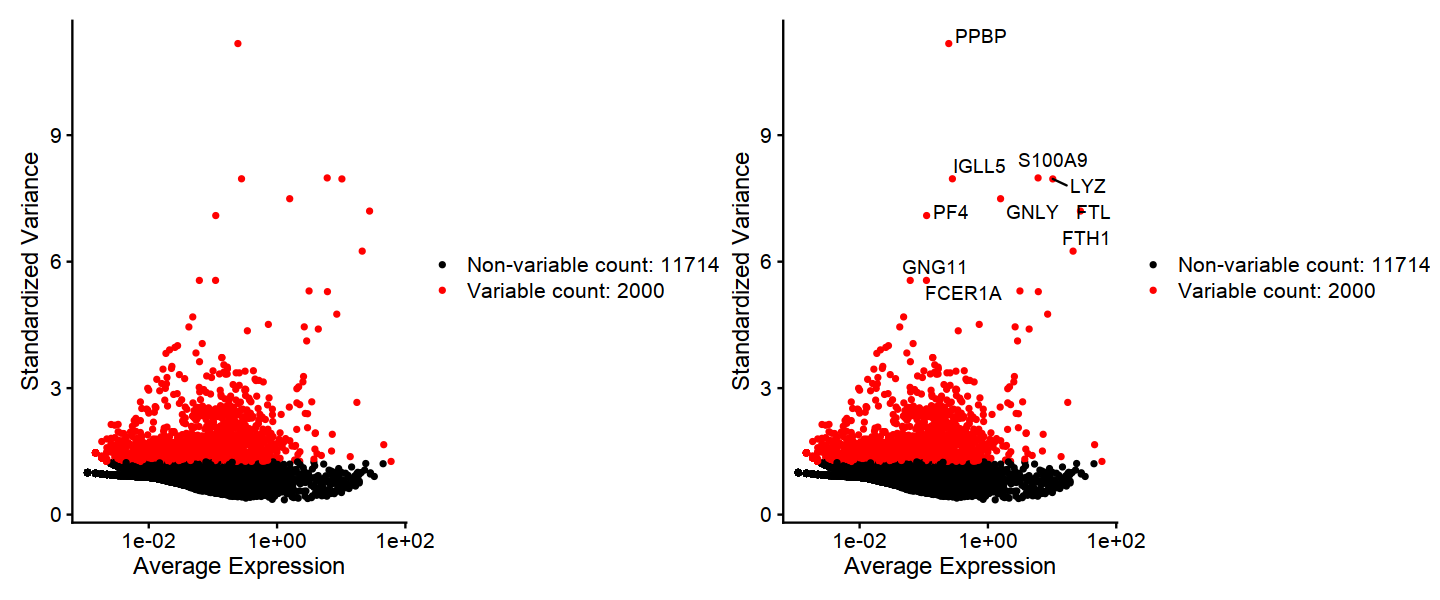

In [4]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc3k), 10)

fig.size(5, 12)
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc3k)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

In [41]:
# Seurat:::FindVariableFeatures.Assay

In [50]:
# ?FindVariableFeatures

## reimplement

In [11]:
# Seurat:::FindVariableFeatures.default

In [53]:
object <- pbmc3k@assays$RNA@data
object[1:5, 1:5]
dim(object)


5 x 5 sparse Matrix of class "dgCMatrix"
              AAACATACAACCAC AAACATTGAGCTAC AAACATTGATCAGC AAACCGTGCTTCCG
AL627309.1                 .              .              .              .
AP006222.2                 .              .              .              .
RP11-206L10.2              .              .              .              .
RP11-206L10.9              .              .              .              .
LINC00115                  .              .              .              .
              AAACCGTGTATGCG
AL627309.1                 .
AP006222.2                 .
RP11-206L10.2              .
RP11-206L10.9              .
LINC00115                  .

[1] 13714  2700

In [205]:
devtools::load_all('.')

Loading singlecellmethods



In [212]:
vargenes_vst_seu <- function(object, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    ## row means
    hvf.info <- data.frame(mean = Matrix::rowMeans(object))

    ## row vars
    hvf.info$variance <- Seurat:::SparseRowVar2(mat = object, mu = hvf.info$mean, display_progress = FALSE)

    ## initialize
    hvf.info$variance.expected <- 0
    hvf.info$variance.standardized <- 0

    not.const <- hvf.info$variance > 0

    ## loess curve fit 
    fit <- loess(formula = log10(x = variance) ~ log10(x = mean), 
        data = hvf.info[not.const, ], span = loess.span)

    ## extract fitted variance 
    hvf.info$variance.expected[not.const] <- 10^fit$fitted

    ## get row standard deviations after clipping
    hvf.info$variance.standardized <- Seurat:::SparseRowVarStd(
        mat = object, 
        mu = hvf.info$mean, 
        sd = sqrt(hvf.info$variance.expected), 
        vmax = clip.max, 
        display_progress = FALSE
    )
    colnames(x = hvf.info) <- paste0("vst.", colnames(x = hvf.info))

    hvf.info <- hvf.info %>% 
        tibble::rownames_to_column('symbol') %>% 
        arrange(-vst.variance.standardized) %>% 
        tibble::rowid_to_column('rank')    
    
    return(hvf.info)
}


In [152]:
hvf.info <- vargenes_vst(object)
head(hvf.info)


,rank,symbol,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,PPBP,0.2451852,9.577506,0.5888573,11.172765
2,2,S100A9,6.0466667,278.681037,34.8969051,7.985838
3,3,IGLL5,0.2792593,8.894938,0.6929479,7.965360
4,4,LYZ,10.2466667,564.108825,70.8492711,7.962098
5,5,GNLY,1.5740741,45.239046,6.0378423,7.492585
6,6,FTL,27.6674074,2008.688897,278.9968379,7.199683


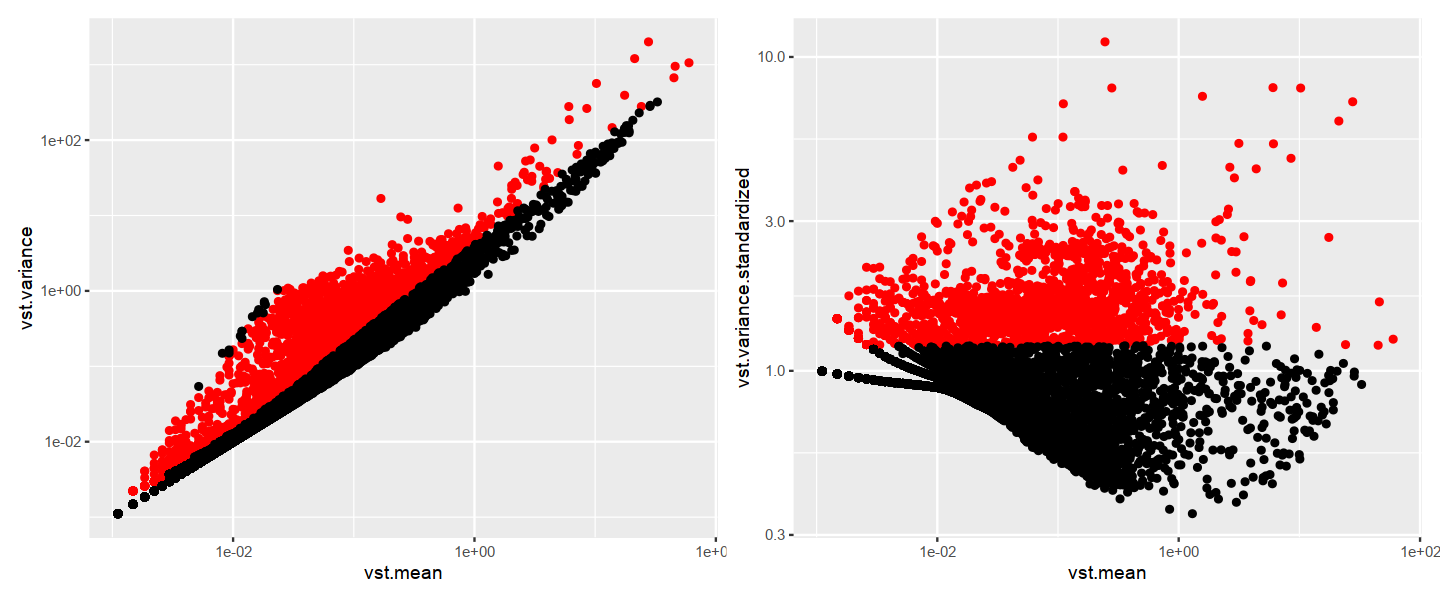

In [145]:
fig.size(5, 12)
hvf.info %>% 
    cbind(isvar = ifelse(mres$z[, 1] > .5, 'no', 'yes')) %>% 
    ggplot(aes(vst.mean, vst.variance, color = rank <= 2143)) + 
#     ggplot(aes(vst.mean, vst.variance, color = isvar)) + 
        geom_point() + 
        scale_x_log10() + scale_y_log10() + 
        scale_color_manual(values = c('black', 'red')) + 
        guides(color = FALSE) + 
hvf.info %>% 
    cbind(isvar = ifelse(mres$z[, 1] >.5, 'no', 'yes')) %>% 
    ggplot(aes(vst.mean, vst.variance.standardized, color = rank <= 2143)) + 
#     ggplot(aes(vst.mean, vst.variance.standardized, color = isvar)) + 
        geom_point() + 
        scale_x_log10() + scale_y_log10() + 
        scale_color_manual(values = c('black', 'red')) + 
        guides(color = FALSE) + 
        NULL

### SparseRowVar2

In [172]:
devtools::load_all('.')

Loading singlecellmethods

Re-compiling singlecellmethods



─  installing *source* package ‘singlecellmethods’ ... (356ms)
   ** using staged installation
   ** libs
   /PHShome/ik936/anaconda3/bin/x86_64-conda_cos6-linux-gnu-c++ -std=gnu++11 -I"/PHShome/ik936/anaconda3/lib/R/include" -DNDEBUG  -I"/PHShome/ik936/anaconda3/lib/R/library/Rcpp/include" -I"/PHShome/ik936/anaconda3/lib/R/library/RcppArmadillo/include" -I/data/srlab/ik936/include -L/data/srlab/ik936/lib -I/apps/lib-osver/gcc/7.1.0/include/ -L/apps/lib-osver/gcc/7.1.0/lib64/ -I/apps/lib-osver/gcc/6.3.0//include -L/apps/lib-osver/gcc/6.3.0/lib64 -I/source/zlib/1.2.11/include -L/source/zlib/1.2.11/lib -I/source/bzip2/1.0.6/include -L/source/bzip2/1.0.6/lib -I/source/lzma/5.0.7/include -L/source/lzma/5.0.7/lib -I//apps/lib-osver/pcre/8.38/include -L/apps/lib-osver/pcre/8.38/lib -I/source/libcurl/7.35.0/include -I/source/libcurl/7.35.0/lib -I/PHShome/ik936/anaconda3/include -L/PHShome/ik936/anaconda3/lib -L/apps/source/boost/1.54/lib -I/apps/source/boost/1.54/include  -fpic  -g -O3 -c Rcp

In [165]:
mu <- Matrix::rowMeans(object)

In [166]:
res1 <- Seurat:::SparseRowVar2(mat = object, mu = mu, display_progress = FALSE)


In [173]:
library(singlecellmethods)
res2 <- singlecellmethods::rowVars(object, mu)


In [175]:
max(abs(res1 - res2))

[1] 1.421085e-14

### SparseRowVarStd

In [214]:
devtools::load_all('.')

Loading singlecellmethods



In [196]:
hvg <- tibble(
    mu = mu,
    sig2 = res2
)

fit <- loess(formula = log10(sig2) ~ log10(mu), 
    data = hvg, span = loess.span)

## extract fitted variance 
variance.expected <- 10^fit$fitted


In [201]:
x1 <- Seurat:::SparseRowVarStd(
    mat = object, 
    mu = mu, 
    sd = sqrt(variance.expected), 
    vmax = 50, 
    display_progress = FALSE
)


In [207]:
x2 <- singlecellmethods::rowVarsStd(object, mu, sqrt(variance.expected), 50)


In [209]:
max(abs(x1 - x2))

[1] 8.881784e-16

### full method

In [218]:
library(singlecellmethods)
system.time({
    hvg1 <- vargenes_vst_seu(object)    
})

system.time({
    hvg2 <- singlecellmethods::vargenes_vst(object)
})

   user  system elapsed 
  0.624   0.025   0.649 

   user  system elapsed 
  0.465   0.006   0.471 

In [219]:
max(abs(hvg1$vst.variance.standardized - hvg2$variance.standardized))

[1] 8.881784e-16

## within cell type, e.g. 

In [258]:
devtools::load_all('.')

Loading singlecellmethods



In [261]:
singlecellmethods::vargenes_vst(object, topn=100) %>% head
singlecellmethods::vargenes_vst(object) %>% head


[1] "PPBP"   "S100A9" "IGLL5"  "LYZ"    "GNLY"   "FTL"

,symbol,rank,mean,variance,variance.expected,variance.standardized
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,PPBP,1,0.2451852,9.577506,0.5888573,11.172765
2,S100A9,2,6.0466667,278.681037,34.8969051,7.985838
3,IGLL5,3,0.2792593,8.894938,0.6929479,7.965360
4,LYZ,4,10.2466667,564.108825,70.8492711,7.962098
5,GNLY,5,1.5740741,45.239046,6.0378423,7.492585
6,FTL,6,27.6674074,2008.688897,278.9968379,7.199683


In [265]:
singlecellmethods::vargenes_vst(object, pbmc3k@meta.data$seurat_annotations) %>% head
singlecellmethods::vargenes_vst(object, pbmc3k@meta.data$seurat_annotations, topn=10) %>% length


,group,symbol,rank,mean,variance,variance.expected,variance.standardized
,<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Naive CD4 T,OXLD1,1,0.1879484,3.494797,0.3060865,8.121212
2,Naive CD4 T,HDAC1,2,0.2984218,6.968288,0.5340029,8.077843
3,Naive CD4 T,C21orf33,3,0.2123386,4.770939,0.3535484,8.058871
4,Naive CD4 T,C17orf62,4,0.2338594,3.716783,0.3969710,7.802942
5,Naive CD4 T,PARP1,5,0.1836442,3.500709,0.2978462,6.789346
6,Naive CD4 T,VTI1B,6,0.1750359,2.150353,0.2814452,6.669033


[1] 90

# Weighted PCA

In [2]:
library(dplyr)
library(purrr)
# list.files('src/', pattern='*.o$', full.names=TRUE) %>% map(file.remove)
devtools::load_all()

ℹ Loading singlecellmethods



## Load data 

In [8]:
# SeuratData::InstallData('pbmc3k')

In [52]:
suppressWarnings({
    SeuratData::LoadData('pbmc3k')    
})
pbmc3k <- pbmc3k[, which(!is.na(pbmc3k@meta.data$seurat_annotations))] ## remove NA annotations
table(pbmc3k@meta.data$seurat_annotations)

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)


 Naive CD4 T Memory CD4 T   CD14+ Mono            B        CD8 T FCGR3A+ Mono 
         697          483          480          344          271          162 
          NK           DC     Platelet 
         155           32           14 

In [53]:
## Run standard stuff for Seurat
pbmc3k <- pbmc3k %>% 
    NormalizeData(verbose = FALSE) %>%  
    FindVariableFeatures(verbose = FALSE) %>% 
    ScaleData(verbose = FALSE) %>% 
    RunPCA(npcs=20, verbose = FALSE) %>% 
    RunUMAP(dims=1:20, verbose = FALSE) 


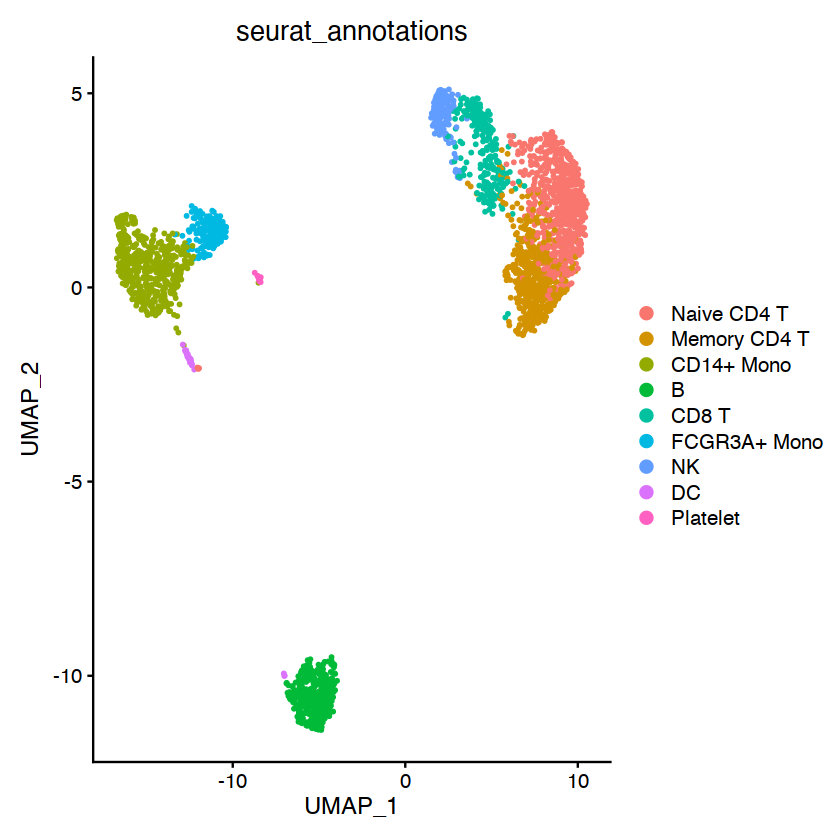

In [54]:
# fig.size(4, 6)
DimPlot(pbmc3k, group.by = 'seurat_annotations')

## new Seurat function


In [33]:
# pbmc3k@assays$RNA@var.features
# pbmc3k@assays$RNA@data

In [93]:
# assay <- assay %||% DefaultAssay(object = object)
# assay.data <- GetAssay(object = object, assay = assay)
# reduction.data <- RunPCA(object = assay.data, assay = assay, 
#     features = features, npcs = npcs, rev.pca = rev.pca, 
#     weight.by.var = weight.by.var, verbose = verbose, ndims.print = ndims.print, 
#     nfeatures.print = nfeatures.print, reduction.key = reduction.key, 
#     seed.use = seed.use, ...)
# object[[reduction.name]] <- reduction.data
# object <- LogSeuratCommand(object = object)
# return(object)

In [172]:
RunBalancedPCA <- function(obj, weight.by='orig.ident', npcs=20, assay.use='RNA', reduction.name = "pca", reduction.key = "PC_") {
    if (!weight.by %in% colnames(obj@meta.data)) 
        stop(glue('Variable {weight.by} not defined in this object'))
    if (length(unique(obj@meta.data[[weight.by]])) == 1) 
        stop(glue('Only 1 level found for {weight.by}. Balanced PCA requires at least 2.'))
    if (any(is.na(obj@meta.data[[weight.by]])))
        stop(glue('Balanced PCA must have non-NA values in {weight.by} variable for all cells'))
    
    y <- obj@meta.data[[weight.by]]
    weights <- as.numeric(((1 / table(y))[y]) * (length(y) / length(unique(y))))    
    pca_res <- weighted_pca(
        obj@assays[[assay.use]]@data, 
        weights, 
        obj@assays[[assay.use]]@var.features,
        npcs,
        scale_thresh=10
    )

    ## Put it back into Seurat 
    obj@assays[[assay.use]]@meta.features <- obj@assays[[assay.use]]@meta.features %>% 
        tibble::rownames_to_column('symbol') %>% 
        left_join(dplyr::rename(pca_res$vargenes, balanced_pca_mean = mean, balanced_pca_stddev = stddev)) %>% 
        tibble::column_to_rownames('symbol')
    obj[[reduction.name]] <- Seurat::CreateDimReducObject(
        embeddings = pca_res$embeddings,
        loadings = pca_res$loadings, 
        stdev = as.numeric(apply(pca_res$embeddings, 2, stats::sd)),
        assay = assay.use,
        key = reduction.key
    )
    return(obj)
}



In [150]:
obj <- pbmc3k %>% 
    RunBalancedPCA(, 'seurat_annotations') %>% 
    RunUMAP(dims=1:20, verbose = FALSE) 


Joining, by = "symbol"



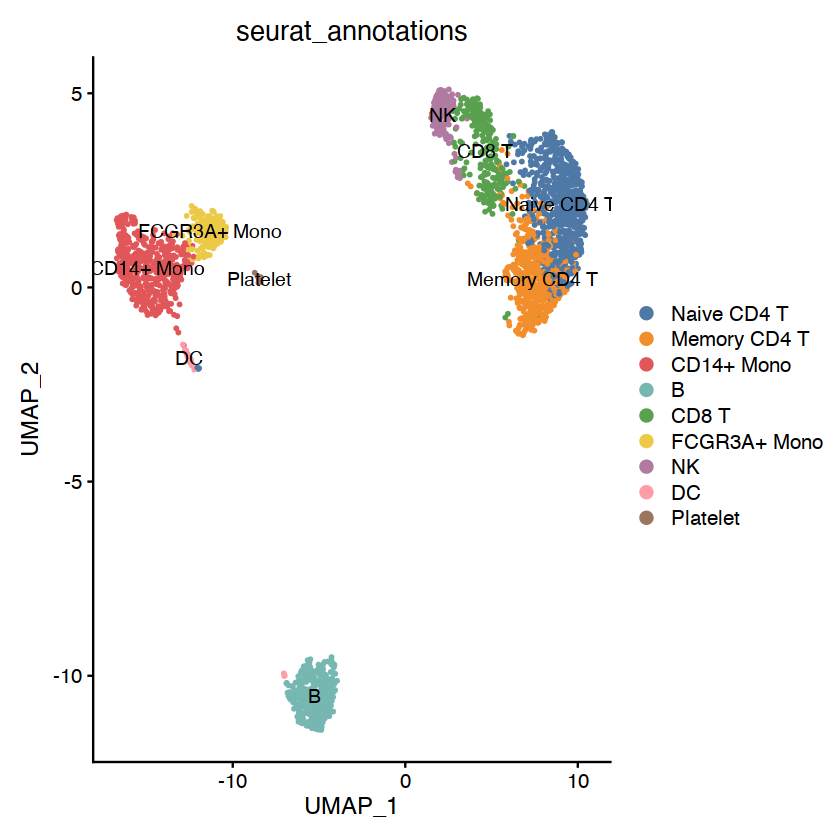

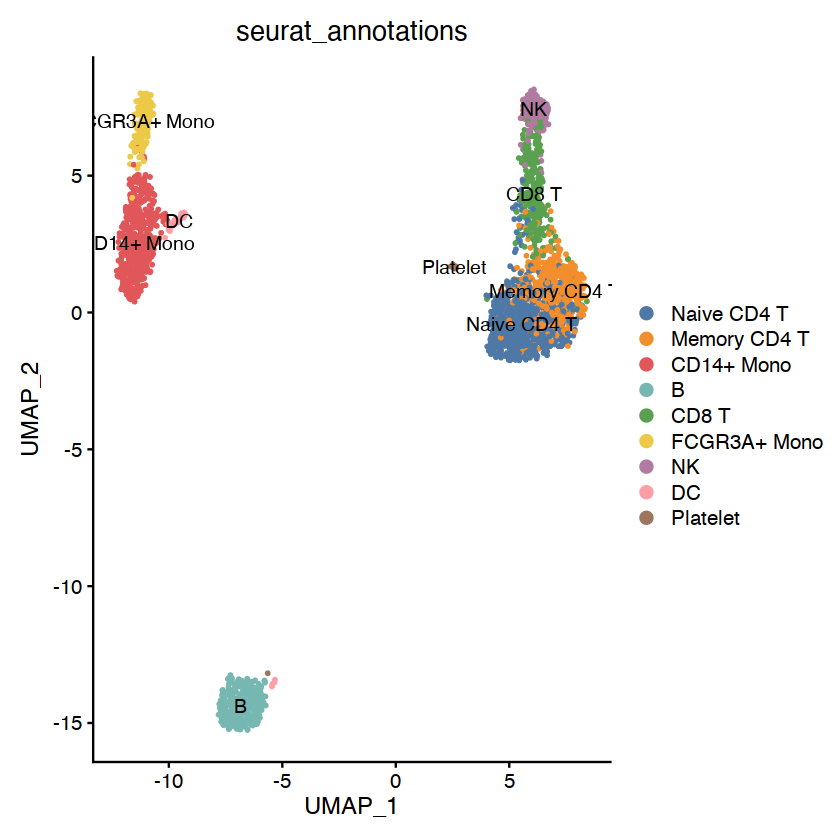

In [171]:
library(ggthemes)
# DimPlot(pbmc3k, group.by = 'seurat_annotations', reduction = 'pca', cols = tableau_color_pal()(10), shuffle = TRUE, label = TRUE)
# DimPlot(obj, group.by = 'seurat_annotations', reduction = 'pca', cols = tableau_color_pal()(10), shuffle = TRUE, label = TRUE)
DimPlot(pbmc3k, group.by = 'seurat_annotations', reduction = 'umap', cols = tableau_color_pal()(10), shuffle = TRUE, label = TRUE)
DimPlot(obj, group.by = 'seurat_annotations', reduction = 'umap', cols = tableau_color_pal()(10), shuffle = TRUE, label = TRUE)


## Test from package 

In [19]:
library(dplyr)
library(purrr)
# list.files('src/', pattern='*.o$', full.names=TRUE) %>% map(file.remove)
# devtools::load_all()
library(singlecellmethods)

In [12]:
# devtools::install_git('.', force=TRUE)


'/usr/bin/git' clone --depth 1 --no-hardlinks . /var/folders/gh/w2gs0rb54mn0s4q84lgy9qvw0000gp/T//RtmpPo1LXR/fileacf339d3f11a



tibble       (3.1.5      -> 3.1.6     ) [CRAN]
generics     (0.1.0      -> 0.1.1     ) [CRAN]
cpp11        (0.4.0      -> 0.4.1     ) [CRAN]
RcppArmad... (0.10.7.0.0 -> 0.10.7.3.0) [CRAN]


Installing 4 packages: tibble, generics, cpp11, RcppArmadillo




The downloaded binary packages are in
	/var/folders/gh/w2gs0rb54mn0s4q84lgy9qvw0000gp/T//RtmpPo1LXR/downloaded_packages
✔  checking for file ‘/private/var/folders/gh/w2gs0rb54mn0s4q84lgy9qvw0000gp/T/RtmpPo1LXR/fileacf339d3f11a/DESCRIPTION’
─  preparing ‘singlecellmethods’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘singlecellmethods_0.1.0.tar.gz’
   


In [11]:
# devtools::document()

In [20]:
suppressWarnings({
    obj <- SeuratData::LoadData('pbmc3k')    
})

obj <- obj[, which(!is.na(obj@meta.data$seurat_annotations))] ## remove NA annotations
table(obj@meta.data$seurat_annotations)


 Naive CD4 T Memory CD4 T   CD14+ Mono            B        CD8 T FCGR3A+ Mono 
         697          483          480          344          271          162 
          NK           DC     Platelet 
         155           32           14 

In [21]:
obj <- obj %>% 
    NormalizeData(verbose = FALSE) %>%  
    FindVariableFeatures(verbose = FALSE) %>% 
    ScaleData(verbose = FALSE) %>% 
    singlecellmethods::RunBalancedPCA('seurat_annotations', npcs=20) %>% 
    RunUMAP(dims=1:20, verbose = FALSE) 


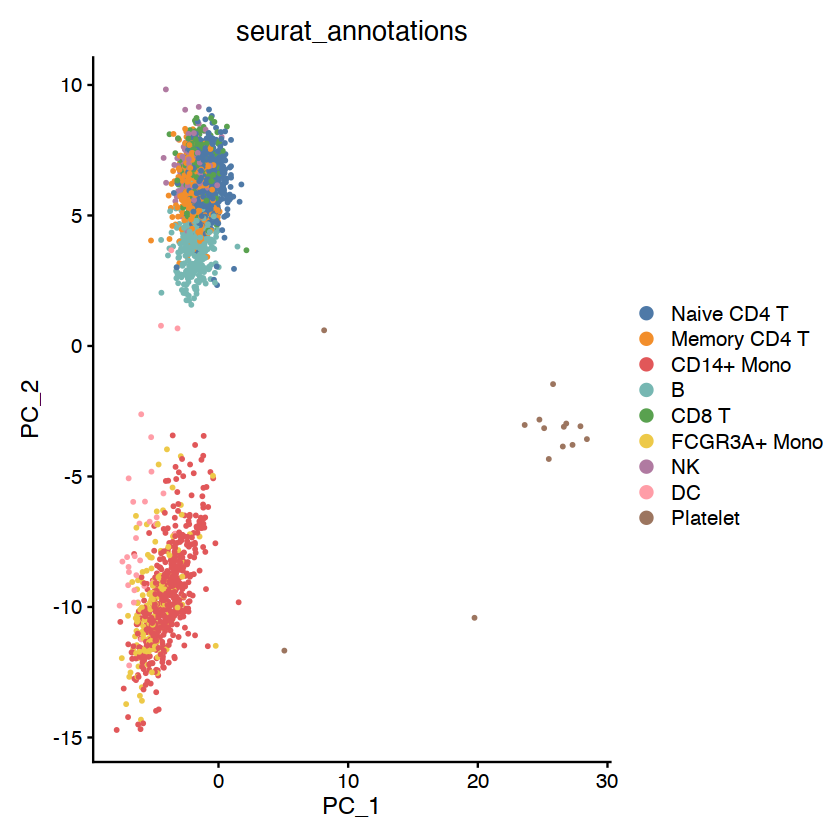

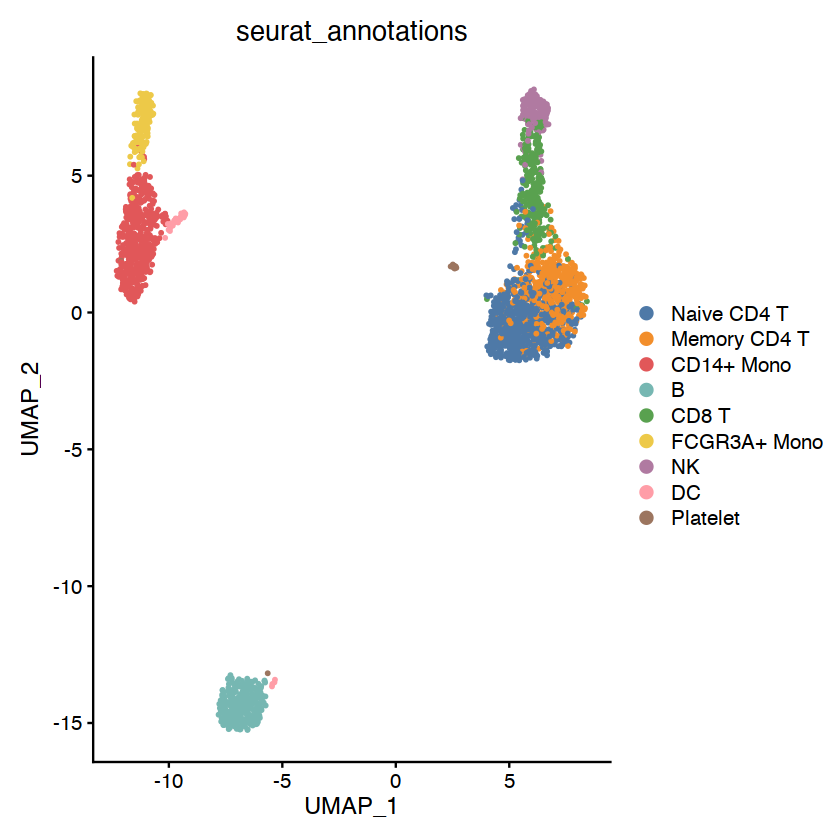

In [22]:
library(ggthemes)
DimPlot(obj, group.by = 'seurat_annotations', reduction = 'pca', cols = tableau_color_pal()(10), shuffle = TRUE)
DimPlot(obj, group.by = 'seurat_annotations', reduction = 'umap', cols = tableau_color_pal()(10), shuffle = TRUE)


## Share with others

In [ ]:
devtools::install_github('immunogenomics/singlecellmethods')
library(singlecellmethods)
library(dplyr)

obj <- obj %>% 
    NormalizeData(verbose = FALSE) %>%  
    FindVariableFeatures(verbose = FALSE) %>% 
    ScaleData(verbose = FALSE) %>% 
    singlecellmethods::RunBalancedPCA('batch', npcs=20) %>% 
    RunUMAP(dims=1:20, verbose = FALSE) 

